<a href="https://colab.research.google.com/github/alexanderknysh/adcpml/blob/main/adcpml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A machine learning algorithm for near-shore ADCP data processing

The following machine learning study aims to select several typical and several anomalous loadcases (about 20-30 loadcases in total) from a detailed ADCP datasets obtained by the Wood Island research site, Maine, USA. Two ADCPs measured water depth, significant wave height and period, as well as north and east projections of current velocity profiles during a half of a month period. More details on the research can be found in [Section 3.2 of this paper](https://github.com/alexanderknysh/adcpml/blob/main/paper.pdf).

## Data formatting
Before we start processing the ADCP datasets, let's first list the libraries needed for the analysis

In [2]:
# required libraries
import pandas as pd
import numpy  as np
import math   as m
import matplotlib.pyplot   as     plt
from collections           import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import KMeans
from sklearn               import metrics

and define a function that will format velocity profiles to the total fluid energy in the upper ocean layers:

In [3]:
# function that format velocity profile datasets
def format_profile(data, top): 
  output = np.empty((0,top))
  for i in range(data.shape[0]):
    row = data[i]
    row = row[np.logical_not(np.isnan(row))]
    row = row[-top:]
    row = np.dot(row, row)
    output = np.append(output, row)
  return output

Next, upload the datasets from the [following GitHub repository](https://github.com/alexanderknysh/adcpml):

In [4]:
# upload datasets common for both adcps:  wave properties and water depth
adcpdata = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/data_adcp_cm.xlsx?raw=true')

# upload velocity dataset: west and east adpc profiles
west_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vx.xlsx?raw=true')
west_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vy.xlsx?raw=true')
east_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vx.xlsx?raw=true')
east_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vy.xlsx?raw=true')

# other important data
samples = range(0, adcpdata.shape[0]) # range of field samples
alpha   = 13*m.pi/180                 # major axis of tidal ellipse (13 degrees)
cells   = 9                           # number of velocity measurement cells

In ocean engineering, tidal-driven current velocities are usually represented in terms of projections on major and minor axes of a tidal ellipse. In this study, we are mostly interested in the major projections since they have the highest absolute values of current velocities. Both west and east major velocity profiles are converted to the energy values that represent total kinetic energy in the upper water layers (4 meters deep). This also reduce number of features we have to deal with in the future.

In [5]:
# project the velocity profiles on the major axis of the tidal ellipse
# save as numpy array to ease further formatting
# convert profiles to relative energy
west_major = west_vx * m.cos(alpha) - west_vy * m.sin(alpha)
east_major = east_vx * m.cos(alpha) - east_vy * m.sin(alpha)
west_major = west_major.to_numpy()
east_major = east_major.to_numpy()
adcpdata['WestEnergy'] = format_profile(west_major, cells)
adcpdata['EastEnergy'] = format_profile(east_major, cells)

# display the resulting dataset
display(adcpdata)

,Date,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,2019-05-16 14:15:00.000,9.475,0.235,11.075,0.174540,0.136834
1,2019-05-16 14:30:00.000,9.395,0.250,12.150,0.271423,0.177364
2,2019-05-16 14:44:59.990,9.289,0.240,11.370,0.249177,0.214879
3,2019-05-16 14:59:59.985,9.160,0.235,11.555,0.355531,0.250243
4,2019-05-16 15:14:59.980,9.007,0.210,11.640,0.471080,0.328769
...,...,...,...,...,...,...
1157,2019-05-28 15:29:54.215,7.275,0.275,8.780,0.025099,0.019459
1158,2019-05-28 15:44:54.210,7.176,0.260,8.640,0.063899,0.029413
1159,2019-05-28 15:59:54.205,7.083,0.260,8.660,0.072142,0.073600
1160,2019-05-28 16:14:54.200,7.040,0.280,8.360,0.097749,0.094061


Let's now visualize the final dataset using Matplotlib:

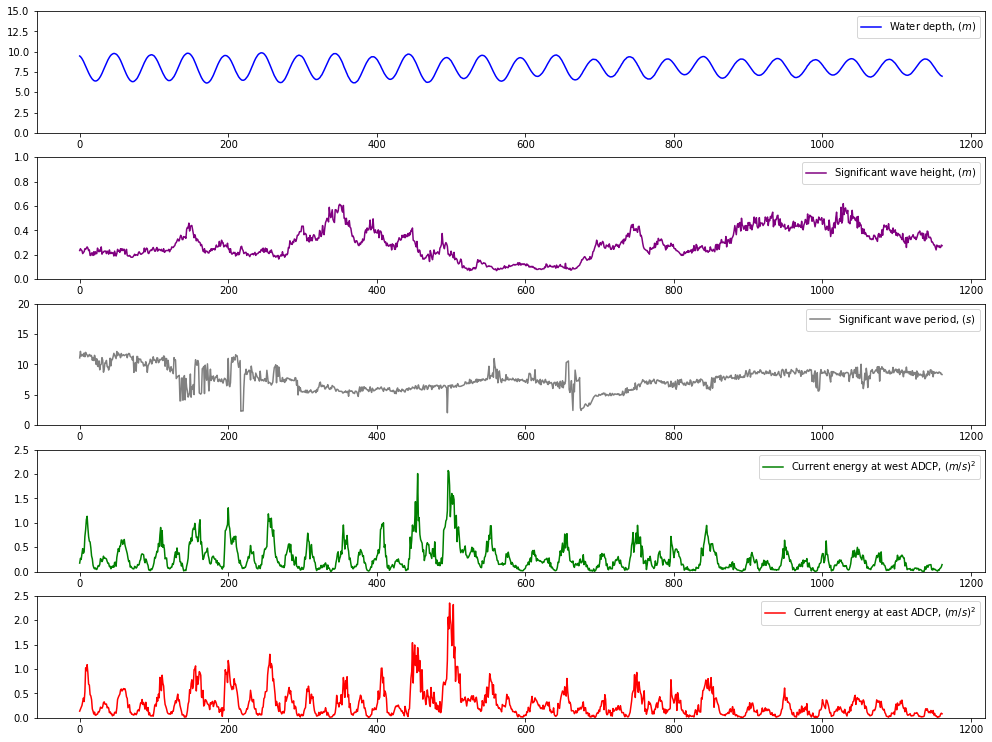

In [75]:
# visualize the adcp data
fig, axs = plt.subplots(5, figsize=(17, 13))

axs[0].plot(samples, adcpdata.iloc[:,1], c='blue', label='Water depth, $(m)$')
axs[0].set_ylim([0, 15])
axs[0].legend(loc='upper right')

axs[1].plot(samples, adcpdata.iloc[:,2], c='purple', label='Significant wave height, $(m)$')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='upper right')

axs[2].plot(samples, adcpdata.iloc[:,3], c='gray', label='Significant wave period, $(s)$')
axs[2].set_ylim([0, 20])
axs[2].legend(loc='upper right')

axs[3].plot(samples, adcpdata.iloc[:,4], c='green', label='Current energy at west ADCP, $(m/s)^2$')
axs[3].set_ylim([0, 2.5])
axs[3].legend(loc='upper right')

axs[4].plot(samples, adcpdata.iloc[:,5], c='red', label='Current energy at east ADCP, $(m/s)^2$')
axs[4].set_ylim([0, 2.5])
axs[4].legend(loc='upper right')

plt.show()

## Data scaling, principle component analysis

Even though we have processed the raw ADCP data, it must be still modified before using a clustering algorithm. The problem that is ranges of the feature values vary significantly, and it may cause machine learning algorythms to perform poorly. Thus, the so-called **Min-Max scaling** is applied to make all features vary from 0 to 1 (normalization) since there are no significant outliers in the dataset.

In [76]:
# remove the date column and apply min-max scaling
adcpdata_nodate = adcpdata.drop('Date', axis='columns')
scaler = MinMaxScaler()
scaler.fit(adcpdata_nodate)
adcpdata_scaled = scaler.fit_transform(adcpdata_nodate)
adcpdata_scaled = pd.DataFrame(adcpdata_scaled, columns=adcpdata_nodate.columns)

# display scaled data
display(adcpdata_scaled)

,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,0.894624,0.300000,0.893353,0.082943,0.057310
1,0.873118,0.327273,1.000000,0.129743,0.074534
2,0.844624,0.309091,0.922619,0.118997,0.090476
3,0.809946,0.300000,0.940972,0.170372,0.105505
4,0.768817,0.254545,0.949405,0.226188,0.138876
...,...,...,...,...,...
1157,0.303226,0.372727,0.665675,0.010754,0.007429
1158,0.276613,0.345455,0.651786,0.029497,0.011659
1159,0.251613,0.345455,0.653770,0.033479,0.030438
1160,0.240054,0.381818,0.624008,0.045848,0.039133


Take a look at the scaled data.

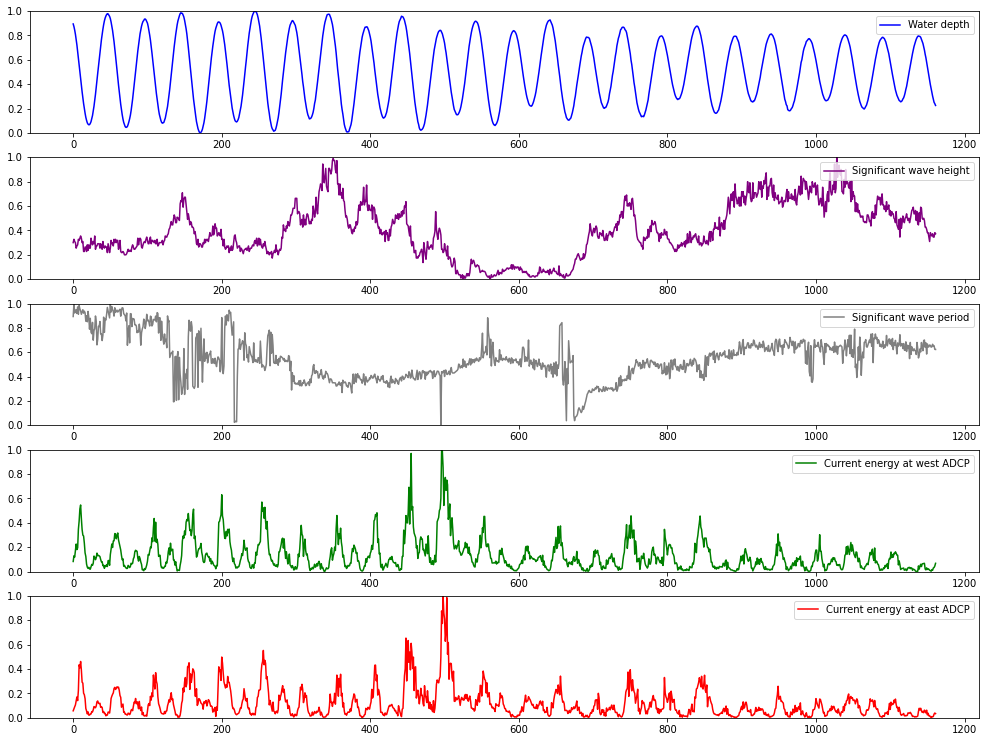

In [86]:
# visualize the adcp data
fig, axs = plt.subplots(5, figsize=(17, 13))

axs[0].plot(samples, adcpdata_scaled.iloc[:,0], c='blue', label='Water depth')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='upper right')

axs[1].plot(samples, adcpdata_scaled.iloc[:,1], c='purple', label='Significant wave height')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='upper right')

axs[2].plot(samples, adcpdata_scaled.iloc[:,2], c='gray', label='Significant wave period')
axs[2].set_ylim([0, 1])
axs[2].legend(loc='upper right')

axs[3].plot(samples, adcpdata_scaled.iloc[:,3], c='green', label='Current energy at west ADCP')
axs[3].set_ylim([0, 1])
axs[3].legend(loc='upper right')

axs[4].plot(samples, adcpdata_scaled.iloc[:,4], c='red', label='Current energy at east ADCP')
axs[4].set_ylim([0, 1])
axs[4].legend(loc='upper right')

plt.show()

While there is not that much correlation between wated depth, significant wave height and significant wave period, the connection between water depth and current energy is very clear. Let's zoom in to see high and low tides:

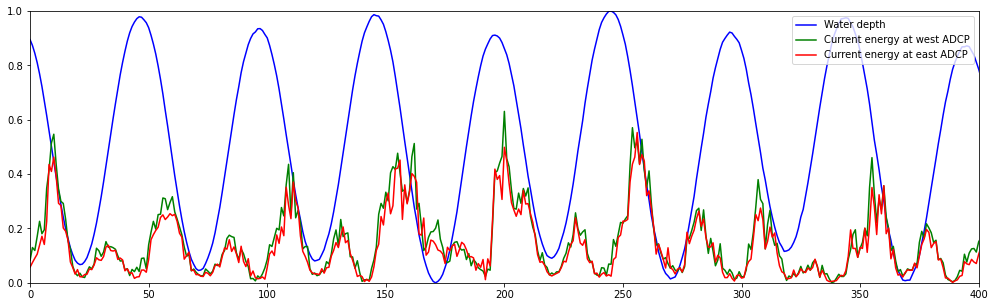

In [88]:
# water depth vs current energy
fig, axs = plt.subplots(figsize=(17, 5))

axs.plot(samples, adcpdata_scaled.iloc[:,0], c='blue', label='Water depth')
axs.plot(samples, adcpdata_scaled.iloc[:,3], c='green', label='Current energy at west ADCP')
axs.plot(samples, adcpdata_scaled.iloc[:,4], c='red', label='Current energy at east ADCP')
axs.set_xlim([0, 400])
axs.set_ylim([0, 1])
axs.legend(loc='upper right')

plt.show()